# Wstęp do Uczenia Maszynowego - Projekt 1
## Autorzy: Katarzyna Solawa, Jan Smoleń


Tematem naszego projektu jest przewidywanie przynależności partyjnej członka Izby Reprezentantów amerykańskiego kongresu w 1986 roku na podstawie dokonanych przez niego wyborów podczas głosowań. Naszym zbiorem danych jest ramka zawierająca dane o przynależności partyjnej poszczególnych reprezentantów i ich głosach podczas 16 kluczowych w tym roku głosowań. 

# Importy

In [3]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics
import random
from sklearn import manifold
random.seed(42)
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
import sklearn.metrics as metrics
import statistics

# EDA

In [4]:
df=pd.read_csv("congressional_voting_dataset.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype 
---  ------                                  --------------  ----- 
 0   handicapped_infants                     435 non-null    object
 1   water_project_cost_sharing              435 non-null    object
 2   adoption_of_the_budget_resolution       435 non-null    object
 3   physician_fee_freeze                    435 non-null    object
 4   el_salvador_aid                         435 non-null    object
 5   religious_groups_in_schools             435 non-null    object
 6   anti_satellite_test_ban                 435 non-null    object
 7   aid_to_nicaraguan_contras               435 non-null    object
 8   mx_missile                              435 non-null    object
 9   immigration                             435 non-null    object
 10  synfuels_corporation_cutback            435 non-null    object
 11  educat

In [6]:
df.head()

,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa,political_party
0,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y,republican
1,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?,republican
2,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n,democrat
3,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y,democrat
4,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y,democrat


## Objaśnienie zmiennych
Kolumny 0-15 zawierają wyniki głosowań na tematy skrótowo opisane w nazwach kolumn. Każdy rząd odpowiada jednemu reprezentantowi. Możliwe wartości: <br>
**y** - głos na tak <br>
**n** - głos na nie <br>
**?** - brak głosu - niewzięcie udziału w głosowaniu lub wstrzymanie się od głosu <br>
Ostatnia kolumna zawiera informacje o przynależności partyjnej reprezentanta - **republican** albo **democrat**. W naszej ramce danych nie występuje bezpośrednio problem braku danych, ale zapewne będzie trzeba jakoś rozwiązać kwestię wartości **?**.

In [7]:
df.describe()

,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa,political_party
count,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435,435
unique,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2
top,n,y,y,n,y,y,y,y,y,y,n,n,y,y,n,y,democrat
freq,236,195,253,247,212,272,239,242,207,216,264,233,209,248,233,269,267


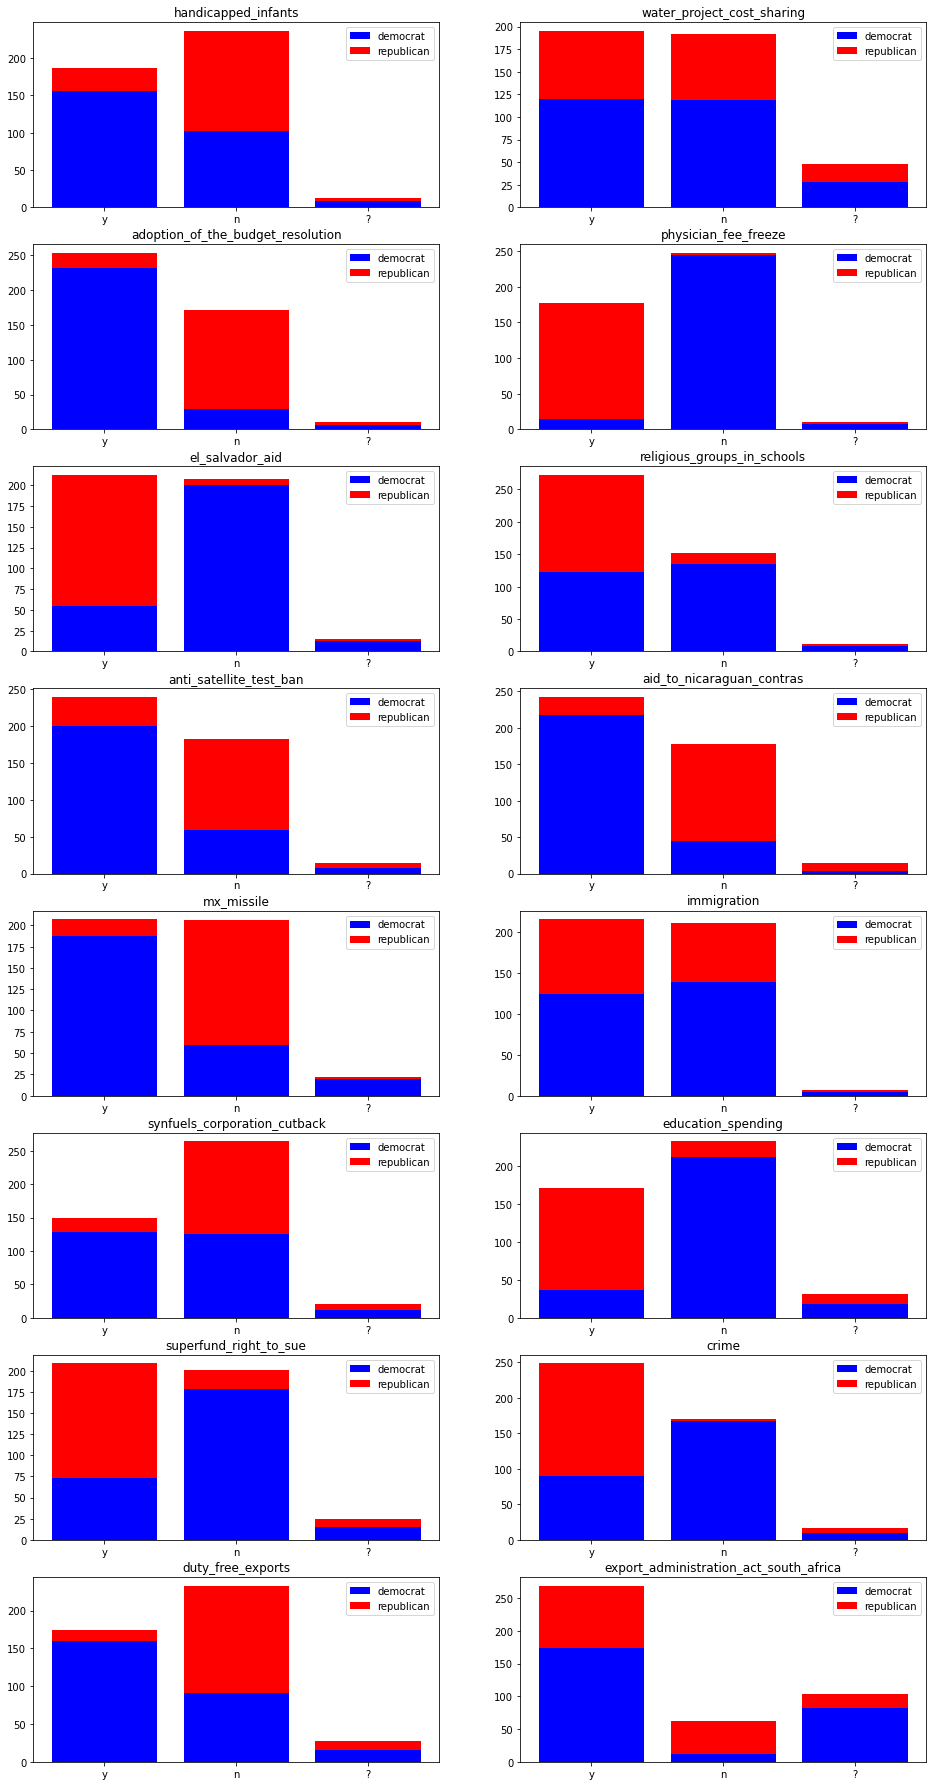

In [8]:
labels=["y", "n", "?"]
fig, axs = plt.subplots(ncols=2, nrows=8, figsize=(16, 32))
for i in range(len(df.columns)-1):
    col=df.columns[i]
    tmp=df[[col, "political_party"]].groupby(["political_party", col]).size().tolist()
    r, c= i//2, i%2
    axs[r,c].bar(labels, list(reversed(tmp[0:3])), label='democrat', color="blue")
    axs[r,c].bar(labels, list(reversed(tmp[3:6])), bottom=list(reversed(tmp[0:3])),
       label='republican', color="red")
    axs[r,c].legend()
    axs[r,c].set_title(col)

Obie partie głosowały podobnie na `water_project_cost_sharing` oraz `imigration`(lecz u demokratów przeważa `no`, a u republikan `yes`)
Widoczna róznica głosów dla:
- `adoption_of_the_budget_resolution`(r-no, d-yes)
- `physician_fee_freeze`(r-yes, d-no)
- `el_salvador_aid`(r-yes, d-no)
- `education_spending`(r-yes, d-no)

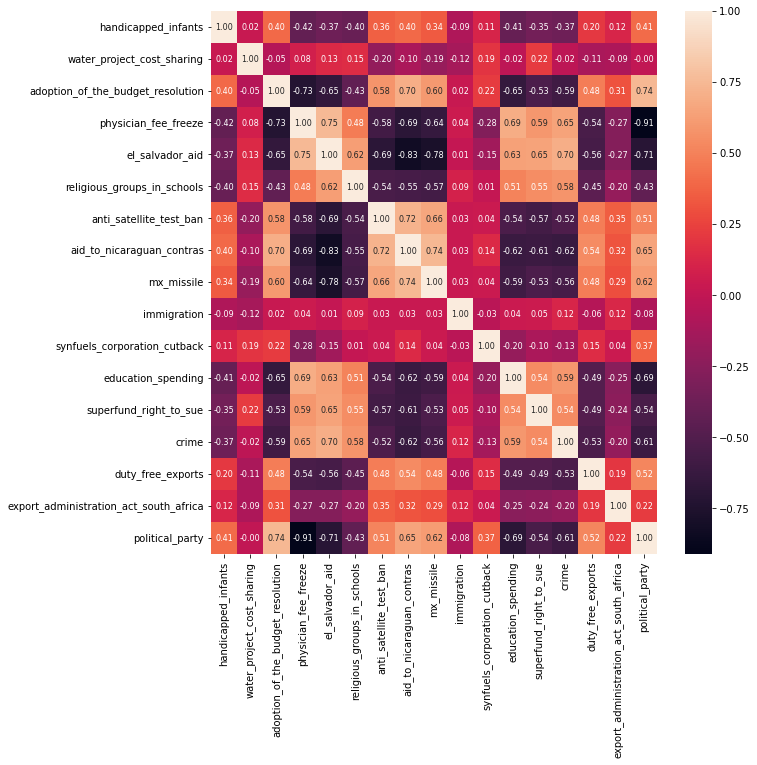

In [9]:
df=df.replace("n", 0)
df=df.replace("y", 1)
df=df.replace("?",  0.5)   #rozwiązanie tymczasowe
df=df.replace("republican", 0)
df=df.replace("democrat",  1)
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, annot_kws={'size': 8}, fmt='.2f')
plt.show()

Jak widzimy, poziom korelacjii pomiędzy głosem a partią bardzo się różni w zależności od tematu głosowania - dla głosowania **water_project_cost_sharing** związek praktycznie nie istnieje, a dla **physician_fee_freeze** jest bardzo duży.

Spróbujemy teraz zobaczyć, na ile głosy poszczególnych reprezentantów przypominają głosy innych członków tej samej partii - w tym celu przekształcimy zapisy głosowań poszczególnych członków na wektory i policzymy odległości pomiędzy każdą parą. 

In [10]:
adist=sklearn.metrics.pairwise_distances(df.drop(["political_party"], axis=1))
adist

array([[0.        , 1.22474487, 2.17944947, ..., 1.22474487, 1.5       ,
        1.22474487],
       [1.22474487, 0.        , 1.93649167, ..., 1.22474487, 1.5       ,
        1.22474487],
       [2.17944947, 1.93649167, 0.        , ..., 1.93649167, 2.54950976,
        2.17944947],
       ...,
       [1.22474487, 1.22474487, 1.93649167, ..., 0.        , 1.5       ,
        1.87082869],
       [1.5       , 1.5       , 2.54950976, ..., 1.5       , 0.        ,
        1.80277564],
       [1.22474487, 1.22474487, 2.17944947, ..., 1.87082869, 1.80277564,
        0.        ]])

Użyjemy teraz funkcji z pakietu manifold żeby przekształcić ramkę zawierającą wzajemne odległości na zbiór współrzędnych na dwuwymiarowej płaszczyźnie. Jest to rzut, który próbuje przekształcić wielowymiarowe zależności na płaszczyznę 2D. 

Text(0.5, 1.0, 'Voting pattern similarity')

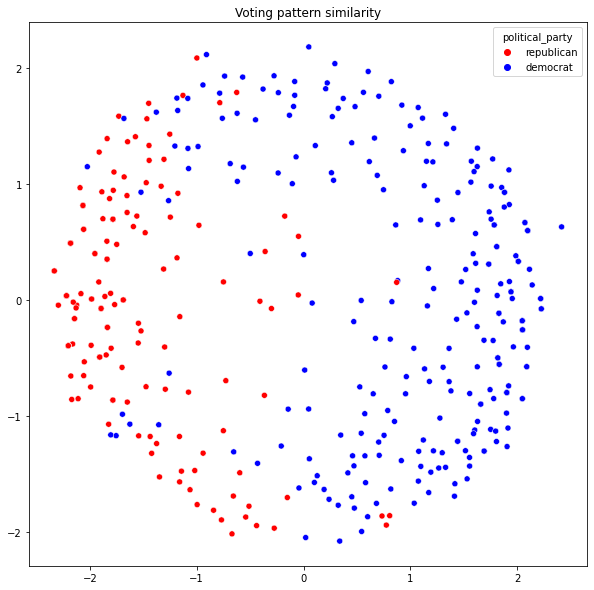

In [11]:
df["political_party"]=df["political_party"].replace(0, "republican")
df["political_party"]=df["political_party"].replace(1, "democrat")
adist=np.array(adist)
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)
coords = results.embedding_
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(
    coords[:, 0], coords[:, 1], marker = 'o', hue=df["political_party"], palette=["red", "blue"]
    )
ax.set_title("Voting pattern similarity")

Dodatkowo sprawdźmy czy któraś z parti ma skołonność do głosowania na tak lub nie.

In [12]:
df=pd.read_csv("congressional_voting_dataset.csv")
democrat_df = df[df['political_party'] == 'democrat']
republican_df = df[df['political_party'] == 'republican']

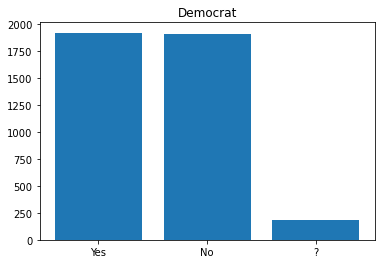

In [13]:
tak = 0
nie = 0
brak = 0
for i in range(0,15):
    tak += (democrat_df[democrat_df.columns[i]] == "y").sum()
    nie += (democrat_df[democrat_df.columns[i]] == "n").sum()
    brak += (democrat_df[democrat_df.columns[i]] == "?").sum()

labels = ['Yes', 'No', '?']
sizes = [tak, nie,brak]
plt.title("Democrat")
plt.bar(labels, sizes)
plt.show()

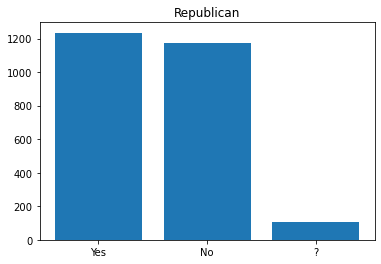

In [14]:
tak = 0
nie = 0
brak = 0
for i in range(0,15):
    tak += (republican_df[republican_df.columns[i]] == "y").sum()
    nie += (republican_df[republican_df.columns[i]] == "n").sum()
    brak += (republican_df[republican_df.columns[i]] == "?").sum()

labels = ['Yes', 'No', '?']
sizes = [tak, nie,brak]
plt.title("Republican")
plt.bar(labels, sizes)
plt.show()

W obu przypadkach licza głosów jest dość wyrównana.

# Feature Engineering

In [15]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics
import random
from sklearn import manifold
import xgboost as xgb
random.seed(42)
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from matplotlib import pyplot 

In [16]:
df=pd.read_csv("congressional_voting_dataset.csv")

### Encoding
W naszych danych kodowanie zmiennych kategorycznych wydaje się nie być dużym wyzwaniem. Głosy na nie oznaczamy jako 0, brak głosu  jako 0.5, a głosy na tak to 1. Podobnie intuicyjnie republikanów oznaczamy jako zera, a demokratów jako jedynki.

In [17]:
df=df.replace("n", 0)
df=df.replace("y", 1)
df=df.replace("?",  0.5)  
df=df.replace("republican", 0)
df=df.replace("democrat",  1)


### Outliers
Ze względu na kategoryczne wartości w naszych danych, nie widzimy tu outlierów w postaci rzędów, które się szczególnie wyróżniają jedną wartością. Jedyny rząd, który odrzucimy to ten, w którym wartości wszystkich głosowań wynosiły "?" - jest to prawdopodobnie brak danych, bądź dany reprezentant z jakiś osobliwych powodów nie wziął udziału w żadnym głosowaniu. 

In [18]:
X=df.drop(["political_party"], axis=1)
indexes=[]
colnames=X.columns
for i in range(len(X)):
    for j in range(len(colnames)):
        if X.iloc[i, j]!=0.5:
            break
        if j==len(colnames)-1:
            indexes.append(i)
X=X.drop(248, axis=0)
y=df["political_party"].drop(248, axis=0)
df=df.drop(248, axis=0)
df.to_csv("df_encoded.csv", index=False)

# Feature Selection
Na początku korzystaliśmy z bardziej intycuicyjnych sposobów wyborów cech, a potem zastosowaliśmy metody pokazane na laboratoriach. Spojrzymy najpierw ponownie na macierz korelacji.


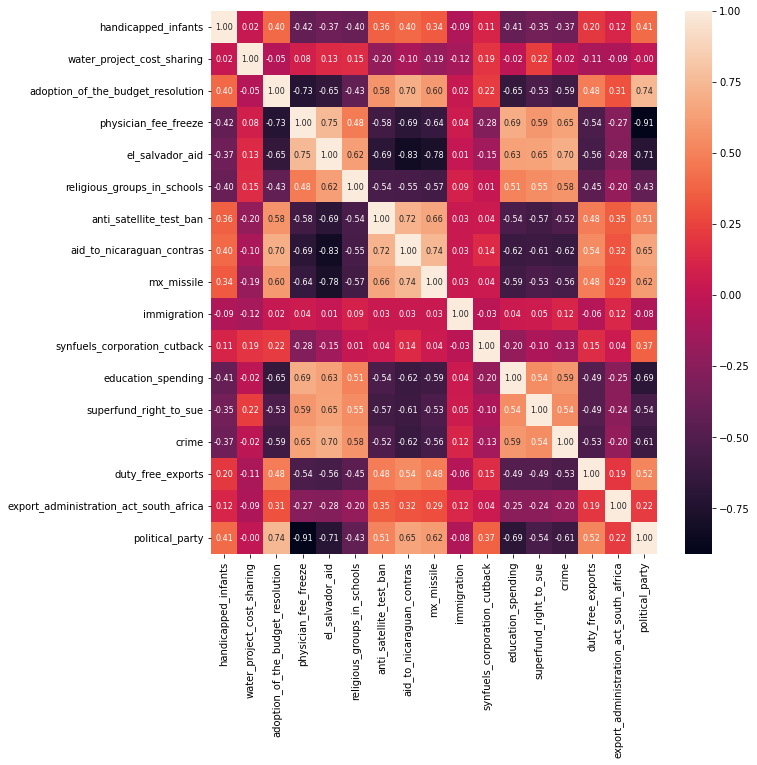

In [19]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True, annot_kws={'size': 8}, fmt='.2f')
plt.show()

Usuniemy dwie zmienne, które w porównaniu z innymi są bardzo mało skorelowane z naszym celem - **water_project_cost_sharing** i **immigration**. Spróbujemy też usunąć zmienną **el_salvador_aid** - mimo, że jest silnie związana z celem, jest także najbardziej skorelowana z innymi zmiennymi objaśniającymi.

In [20]:
drop=["water_project_cost_sharing", "immigration", "el_salvador_aid"]
X=X.drop(drop, axis=1)

### Model
Naszym modelem bazowym, którego dziś użyjemy, będzie xgboost bez tuningu hiperparametrów.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

In [22]:
xgb_model = xgb.XGBClassifier(objective = "binary:logistic", seed = 42, use_label_encoder=False, verbosity=0)
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
comparison = pd.DataFrame({'actual':y_test, 'predicted':preds})
print("Accuracy: " + str(sum(comparison["actual"] == comparison["predicted"]) / len(comparison) * 100) + "%")

Accuracy: 96.55172413793103%


Jak widzimy, nasz model całkiem dobrze sobie radzi z przewidywaniem przynależności do danej partii politycznej - osiąga ponad 96% skuteczności. Na koniec spojrzymy, jak ważne dla niego są poszczególne kolumny - użyjemy do tego wbudowanej funkcji modelu xgb. 

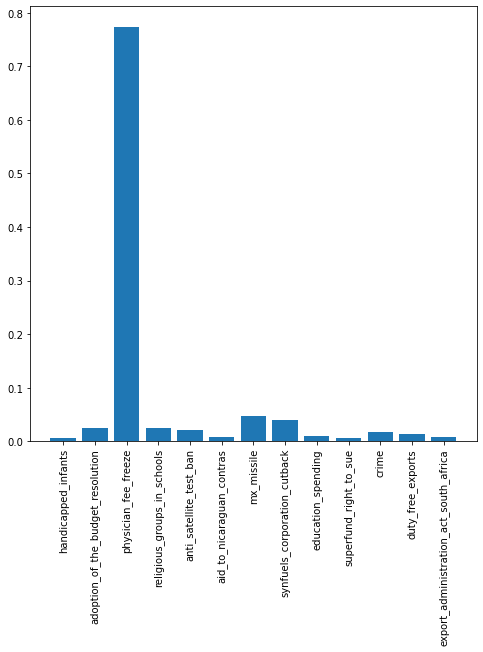

In [23]:
plt.figure(figsize=(8,8))
pyplot.bar(X.columns, xgb_model.feature_importances_)
plt.xticks(rotation=90)
pyplot.show()

Zgodnie z oczekiwaniami wynikającymi z mapy korelacji, zmienna **physicican_fee_freeze** ma olbrzymi wpływ na predykcje naszego modelu. Na koniec spójrzmy jeszcze, jak wyglądała by skuteczność modelu, gdybyśy wybrali jedynie 5 najważniejszych wg wykresu cech.

In [24]:
fts=["physician_fee_freeze", "mx_missile", "synfuels_corporation_cutback", "religious_groups_in_schools", "crime"]
X=X[fts]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)
xgb_model = xgb.XGBClassifier(objective = "binary:logistic", seed = 42, use_label_encoder=False, verbosity=0)
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
comparison = pd.DataFrame({'actual':y_test, 'predicted':preds})
print("Accuracy: " + str(sum(comparison["actual"] == comparison["predicted"]) / len(comparison) * 100) + "%")


Accuracy: 94.25287356321839%


In [25]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics
import random
from sklearn import manifold
random.seed(42)


In [26]:
df=pd.read_csv("congressional_voting_dataset.csv")
df=df.replace("n", 0)
df=df.replace("y", 1)
df=df.replace("?",  0.5)  
df=df.replace("republican", 0)
df=df.replace("democrat",  1)
X=df.drop(["political_party"], axis=1)
indexes=[]
colnames=X.columns
for i in range(len(X)):
    for j in range(len(colnames)):
        if X.iloc[i, j]!=0.5:
            break
        if j==len(colnames)-1:
            indexes.append(i)
X=X.drop(248, axis=0)
y=df["political_party"].drop(248, axis=0)
df.head()

,handicapped_infants,water_project_cost_sharing,adoption_of_the_budget_resolution,physician_fee_freeze,el_salvador_aid,religious_groups_in_schools,anti_satellite_test_ban,aid_to_nicaraguan_contras,mx_missile,immigration,synfuels_corporation_cutback,education_spending,superfund_right_to_sue,crime,duty_free_exports,export_administration_act_south_africa,political_party
0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.5,1.0,1.0,1.0,0.0,1.0,0
1,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.5,0
2,0.5,1.0,1.0,0.5,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1
3,0.0,1.0,1.0,0.0,0.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1
4,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.5,1.0,1.0,1.0,1.0,1


In [27]:
drop=["water_project_cost_sharing", "immigration", "el_salvador_aid"]
X=X.drop(drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)
X_best=None

In [28]:
def selectFeature(selector):
    selector.fit(X_train, y_train)
    X_train_fs = selector.transform(X_train)
    X_test_fs = selector.transform(X_test)
    xgb_model = xgb.XGBClassifier(objective = "binary:logistic", seed = 42, use_label_encoder=False, verbosity=0)
    xgb_model.fit(X_train_fs, y_train)
    yhat = xgb_model.predict(X_test_fs)
    accuracy = accuracy_score(y_test, yhat)
    print('Accuracy: %.2f' % (accuracy*100))


In [29]:
def selectFeature2(selector):
    clf = Pipeline([
      ('feature_selection', SelectFromModel(selector)),
      ('classification', xgb.XGBClassifier(objective = "binary:logistic", seed = 42, use_label_encoder=False, verbosity=0))
    ])
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    accuracy = accuracy_score(y_test, yhat)
    print('Accuracy: %.2f' % (accuracy*100))

### CHI2

In [30]:
for i in range(1,14):
    selectFeature(SelectKBest(chi2, k=i))    


Accuracy: 94.25
Accuracy: 94.25
Accuracy: 94.25
Accuracy: 93.10
Accuracy: 91.95
Accuracy: 90.80
Accuracy: 90.80
Accuracy: 93.10
Accuracy: 94.25
Accuracy: 94.25
Accuracy: 95.40
Accuracy: 95.40
Accuracy: 96.55


Najwyższe accuracy dla wyboru wszytkich 13 zmiennych

### Recursive Feature Elimination

In [31]:
from sklearn.feature_selection import RFE
estimator = LogisticRegression()
for i in range(1,14):
    selectFeature(RFE(estimator, n_features_to_select=i, step=1))

 

Accuracy: 94.25
Accuracy: 94.25
Accuracy: 95.40
Accuracy: 96.55
Accuracy: 96.55
Accuracy: 94.25
Accuracy: 95.40
Accuracy: 95.40
Accuracy: 95.40
Accuracy: 95.40
Accuracy: 96.55
Accuracy: 96.55
Accuracy: 96.55


Najwyższe accuracy przy wyborze min 4 zmiennych

### Mutual info classif

In [32]:
for i in range(1,14):
    selectFeature(SelectKBest(mutual_info_classif, k=i))

Accuracy: 94.25
Accuracy: 94.25
Accuracy: 94.25
Accuracy: 94.25
Accuracy: 94.25
Accuracy: 91.95
Accuracy: 91.95
Accuracy: 93.10
Accuracy: 94.25
Accuracy: 94.25
Accuracy: 96.55
Accuracy: 96.55
Accuracy: 96.55


Najwyższe accuracy przy wyborze min 10 zmiennych

### LinearSVC - Linear Support Vector Classification

In [33]:

# C = 0.005
selectFeature2(LinearSVC(C=0.005, penalty="l1", dual=False))

# C = 0.005
selectFeature2(LinearSVC(C=0.01, penalty="l1", dual=False))

# C = 0.11 
selectFeature2(LinearSVC(C=0.11, penalty="l1", dual=False))

# C = 0.17 
selectFeature2(LinearSVC(C=0.17, penalty="l1", dual=False))

# C = 0.2
selectFeature2(LinearSVC(C=0.2, penalty="l1", dual=False))



Accuracy: 94.25
Accuracy: 94.25
Accuracy: 95.40
Accuracy: 95.40
Accuracy: 95.40


In [34]:
selectFeature2(LinearSVC())#domyślnie C = 1, penalty='l2'

Accuracy: 95.40


Przy wyborze do k najlepszych zmiennych za pomocą chi2 oraz mutual info classif, accuracy jest większe niż 94.25 dla k min równego 42 i 37.

## Wnioski

Metody osiągają max accuracy 96.55, czyli tyle ile udało nam sie osiągnąć przy samodzielnym wyborze zmiennych. </br>  
Używając niedużej ilości zmiennych udało nam się zatem osiągnąć wynik tylko nieznacznie gorszy od bazowego XGBoosta, który wynosił 97%. Jednak ze względu na małą liczbę rekordów i krótki czas wykonywania algorytmów, nie widzeliśmy sensu w ograniczaniu w tym przypadku liczby kolumn.

In [35]:
fts=["physician_fee_freeze","synfuels_corporation_cutback", "adoption_of_the_budget_resolution", "education_spending"]
X2=X[fts]
X_train, X_test, y_train, y_test = train_test_split(X2, y, stratify=y, test_size = 0.2, random_state = 42)
xgb_model = xgb.XGBClassifier(objective = "binary:logistic", seed = 42, use_label_encoder=False, verbosity=0)
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
comparison = pd.DataFrame({'actual':y_test, 'predicted':preds})
print("Accuracy: " + str(sum(comparison["actual"] == comparison["predicted"]) / len(comparison) * 100) + "%")

Accuracy: 96.55172413793103%


In [36]:
xgb_tmp=xgb.XGBClassifier(objective = "binary:logistic", seed = 42, use_label_encoder=False, verbosity=0)

In [37]:
xgb_tmp

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, seed=42, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None, verbosity=0)

In [38]:
y_train

209    1
32     1
346    0
60     1
426    1
      ..
302    0
284    1
149    1
188    0
75     1
Name: political_party, Length: 347, dtype: int64

# Wybór modelu 

In [39]:
df=pd.read_csv("df_encoded.csv")

Chociaż na we wcześniejszym etapie pracy usunęliśmy z naszych danych zduplikowane rzędy, to podczas pracy z modelami okazuje się, że osiągają one lepsze wyniki kiedy je zostawimy.

In [40]:
from sklearn.model_selection import train_test_split
X=df.drop(["political_party"], axis=1)
y=df["political_party"]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,random_state = 42)

Wybraliśmy do przetestowania 3 modele - **SVM**, **Random Forest** i **XGBoost**.

## SVM

In [41]:
svm_base=SVC(random_state=42)
svm_base.fit(X_train, y_train)
preds=svm_base.predict(X_test)

In [42]:
svm_base_acc=accuracy_score(preds,y_test)
print("Accuracy SVM z domyślnymi hiperparametrami: " + str(svm_base_acc))

Accuracy SVM z domyślnymi hiperparametrami: 0.963302752293578


Widzimy, że już domyślny SVM osiąga bardzo dobre accuracy na poziomie ponad 96%. Spróbujemy teraz wykonać tuning hiperparametrów. Ponieważ nasz zbiór danych jest stosunkowo mały, skorzystamy z narzędzia GridSearch.

In [43]:

svm_tuned=SVC(random_state=42)
c=[]  # wartości parametru C
gamma=[]  #wartości parametru gamma 
for i in range(-4, 5):      # orientacyjne wartości na podstawie informacji znalezionych w internecie
    c.append(10**i)
for i in range(-4, 5):
    gamma.append(10**i)
gamma.append("auto")
gamma.append("scale")
params = [{'C': c,   
           "kernel": ["rbf", "linear", "poly"],
        'gamma': gamma}]
gs_svm=GridSearchCV(svm_tuned, param_grid=params, scoring='accuracy', cv=4, n_jobs=2)
gs_svm.fit(X_train, y_train)
gs_svm.best_params_

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [44]:
svm_tuned_acc=accuracy_score(gs_svm.predict(X_test),y_test)
print("Accuracy SVM po tuningu hiperparametrów: " + str(svm_tuned_acc))

Accuracy SVM po tuningu hiperparametrów: 0.9541284403669725


Jak widzimy, nie udało nam się polepszyć wyniku, a nawet uzyskaliśmy accuracy trochę gorsze. Mimo że w naszej ramce danych znajdują się także domyślne wartości hiperparametrów, to wypadły one gorzej przy kroswalidacji i dlatego algorytm ich nie wybrał. Wydaje mi się, że taka sytuacja zachodzi ze względu na małą liczbę rekordów i duże accuracy naszych modeli.

## XGBoost

In [45]:
xgb_base = xgb.XGBClassifier(objective = "binary:logistic", seed = 1613, use_label_encoder=False, verbosity=0)
xgb_base.fit(X_train, y_train)
preds=xgb_base.predict(X_test)

In [46]:
xgb_base_acc=accuracy_score(preds,y_test)
print("Accuracy XGB z domyślnymi hiperparametrami: " + str(xgb_base_acc))

Accuracy XGB z domyślnymi hiperparametrami: 0.9724770642201835


In [47]:
xgb_tuned=xgb.XGBClassifier(objective = "binary:logistic", seed = 1613, use_label_encoder=False, eval_metric="error")
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

gs_xgb=GridSearchCV(xgb_tuned, param_grid=params, scoring='accuracy', cv=4, n_jobs=2)
gs_xgb.fit(X_train, y_train)
gs_xgb.best_params_

{'colsample_bytree': 1.0,
 'gamma': 1,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 0.6}

In [48]:
xgb_tuned_acc=accuracy_score(gs_xgb.predict(X_test), y_test)
print("Accuracy XGB po treningu hiperparametrów: " + str(xgb_tuned_acc))

Accuracy XGB po treningu hiperparametrów: 0.9724770642201835


## Random Forest

In [49]:
rfc_base = RandomForestClassifier(random_state=16)
rfc_base.fit(X_train, y_train)
preds=rfc_base.predict(X_test)

In [50]:
rfc_base_acc=accuracy_score(preds,y_test)
print("Accuracy RFC z domyślnymi hiperparametrami: " + str(rfc_base_acc))

Accuracy RFC z domyślnymi hiperparametrami: 0.9724770642201835


In [51]:
rfc_tuned=RandomForestClassifier(random_state=16)
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 5)] # przykładowe wartości znalezione w internecie 
max_depth = [int(x) for x in np.linspace(5, 55, num = 5)]
max_features= ['auto', 'sqrt', 'log2']
             
params = [{'n_estimators': n_estimators,
        'max_depth': max_depth,
          'max_features': max_features}]
gs_rfc=GridSearchCV(rfc_tuned, param_grid=params, scoring='accuracy', cv=4, n_jobs=2)
gs_rfc.fit(X_train, y_train)
gs_rfc.best_params_

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 50}

In [52]:
rfc_tuned_acc=accuracy_score(gs_rfc.predict(X_test), y_test)
print("Accuracy RFC po treningu hiperparametrów: " + str(rfc_tuned_acc))

Accuracy RFC po treningu hiperparametrów: 0.963302752293578


Jak widać, ani w XGBooście, ani w Random Forest nie udało się uzyskać lepszej niż domyślna accuracy. Co więcej, obydwa bazowe modele osiągają dokładnie ten sam wynik.

# Ocena modeli
## Accuracy score

In [53]:
scores=[]
labels=[]
scores.append(svm_base_acc)
labels.append("SVM")
scores.append(xgb_base_acc)
labels.append("XGB")
scores.append(rfc_base_acc)
labels.append("RFC")

In [54]:
pd.DataFrame({"Accuracy Score": scores}, index=labels)

,Accuracy Score
SVM,0.963303
XGB,0.972477
RFC,0.972477


## Confusion matrix
### SVM

In [55]:
tn, fp, fn, tp = confusion_matrix(y_test, svm_base.predict(X_test)).ravel()
pd.DataFrame({"Actual positives": [tp, fp], "Actual negatives": [fn, tn]}, index = ["Positive predictions", "Negative predictions"])

,Actual positives,Actual negatives
Positive predictions,64,3
Negative predictions,1,41


### XGB 

In [56]:
tn, fp, fn, tp = confusion_matrix(y_test, xgb_base.predict(X_test)).ravel()
pd.DataFrame({"Actual positives": [tp, fp], "Actual negatives": [fn, tn]}, index = ["Positive predictions", "Negative predictions"])

,Actual positives,Actual negatives
Positive predictions,65,2
Negative predictions,1,41


### RFC

In [57]:
tn, fp, fn, tp = confusion_matrix(y_test, xgb_base.predict(X_test)).ravel()
pd.DataFrame({"Actual positives": [tp, fp], "Actual negatives": [fn, tn]}, index = ["Positive predictions", "Negative predictions"])

,Actual positives,Actual negatives
Positive predictions,65,2
Negative predictions,1,41


## ROC AUC

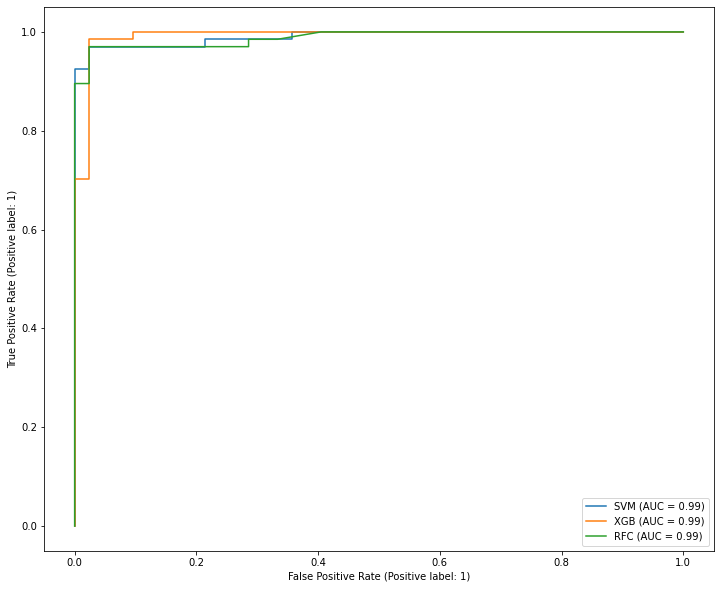

In [58]:
gs_svm
plt.figure(figsize=(12,10))
classifiers = [svm_base, xgb_base, rfc_base]
labels=["SVM", "XGB", "RFC"]
ax = plt.gca()
for i in range(3):
    metrics.plot_roc_curve(classifiers[i], X_test, y_test, ax=ax, name=labels[i])

Na podstawie powyższych wyników zdecydowaliśmy się pozostać przy modelu **XGBoost** bez modyfikacji hiperparametrów czy wyboru zmiennych. W naszym przypadku nawet taki model osiagał bardzo wysokie accuracy, a był przy tym szybki.

# Podsumowanie 
## EDA throwback - które predykcje się udały


In [59]:
df_tmp=pd.read_csv("congressional_voting_dataset.csv")
df_tmp=df_tmp.replace("n", 0)
df_tmp=df_tmp.replace("y", 1)
df_tmp=df_tmp.replace("?",  0.5)                                                  #żeby uzyskać taki sam wykres jak w eda
df_tmp["political_party"]=df_tmp["political_party"].replace("republican", 0)      #musimy użyć ramki danych z rzędem,
df_tmp["political_party"]=df_tmp["political_party"].replace("democrat", 1)        # który wcześniej wyrzucliśmy

y_tmp=df_tmp["political_party"]
X_tmp=df_tmp.drop(["political_party"], axis=1)


xgb_tmp=xgb.XGBClassifier(objective = "binary:logistic", seed = 1613, use_label_encoder=False, verbosity=0)
df_tmp["predicted_correctly"]=False
for i in range(len(df_tmp)):
    X_train_tmp=X_tmp.drop(i, axis=0)
    y_train_tmp=y_tmp.drop(i, axis=0)
    X_test_tmp=X_tmp.iloc[[i]]
    y_test_tmp=y_tmp[i]
    xgb_tmp.fit(X_train_tmp, y_train_tmp)
    pred_tmp=xgb_tmp.predict(X_test_tmp)[0]
    if y_tmp[i]==pred_tmp:
        df_tmp["predicted_correctly"][i]=True
    

In [60]:
adist=sklearn.metrics.pairwise_distances(df_tmp.drop(["political_party", "predicted_correctly"], axis=1))
adist

array([[0.        , 1.22474487, 2.17944947, ..., 1.22474487, 1.5       ,
        1.22474487],
       [1.22474487, 0.        , 1.93649167, ..., 1.22474487, 1.5       ,
        1.22474487],
       [2.17944947, 1.93649167, 0.        , ..., 1.93649167, 2.54950976,
        2.17944947],
       ...,
       [1.22474487, 1.22474487, 1.93649167, ..., 0.        , 1.5       ,
        1.87082869],
       [1.5       , 1.5       , 2.54950976, ..., 1.5       , 0.        ,
        1.80277564],
       [1.22474487, 1.22474487, 2.17944947, ..., 1.87082869, 1.80277564,
        0.        ]])

Text(0.5, 1.0, 'Voting pattern similarity')

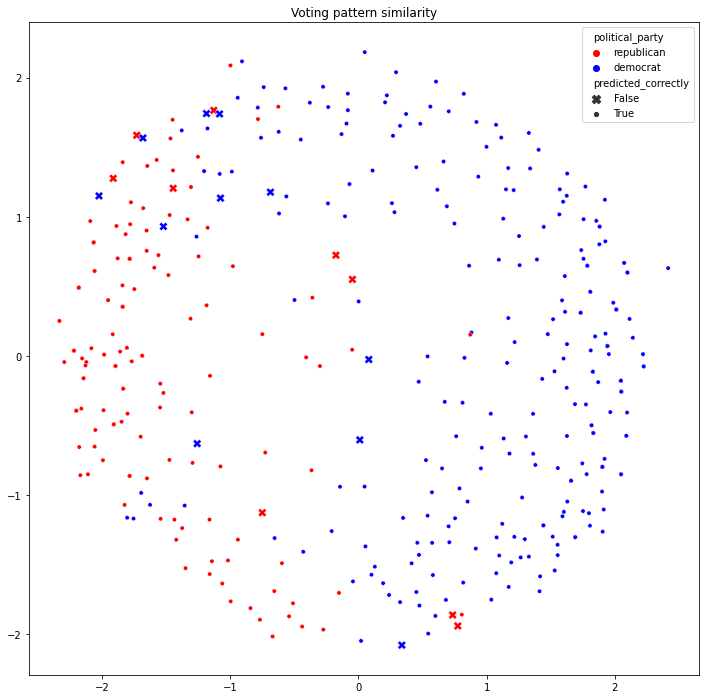

In [61]:
df_tmp["political_party"]=df_tmp["political_party"].replace(0, "republican")
df_tmp["political_party"]=df_tmp["political_party"].replace(1, "democrat")
adist=np.array(adist)
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(adist)
coords = results.embedding_
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(
    coords[:, 0], coords[:, 1], marker = 'o', hue=df_tmp["political_party"], palette=["red", "blue"], 
    style=df_tmp["predicted_correctly"], markers=["X", "o"], size=df_tmp["predicted_correctly"]
    )
ax.set_title("Voting pattern similarity")

Na koniec wróciliśmy do wykresu z naszego EDA żeby zobaczyć, których z reprezentantów udało przewidzieć się prawidłowo – wykonaliśmy w tym celu predykcje na podstawie reszty ramki danych dla każdego pojedynczego rzędu. Jak widać, błędne predykcje zazwyczaj znajdują się w zróżnicowanym pod względem partii otoczeniu. Jednak duża skuteczność nawet dla nieoczywistych polityków  pokazuje świadczy o jakości XGBoosta, nawet bez specjalnego dopasowywania cech czy tuningu hiperparametrów. 